In [47]:
import os
import re
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split   
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
from itertools import product

In [48]:
# Environment Info & GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" PyTorch version:", torch.__version__)
print(" Using device:", device)

 PyTorch version: 2.6.0+cu126
 Using device: cuda


In [49]:
# Data Cleaning
with open('../data/shakespeare.txt', "r", encoding="utf-8") as f:
    text = f.read()
text = re.sub(r'[^\x00-\x7F]+', '', text)
text = re.sub(r'\s+', ' ', text)
print(f"Length of cleaned text: {len(text)}")

Length of cleaned text: 4941134


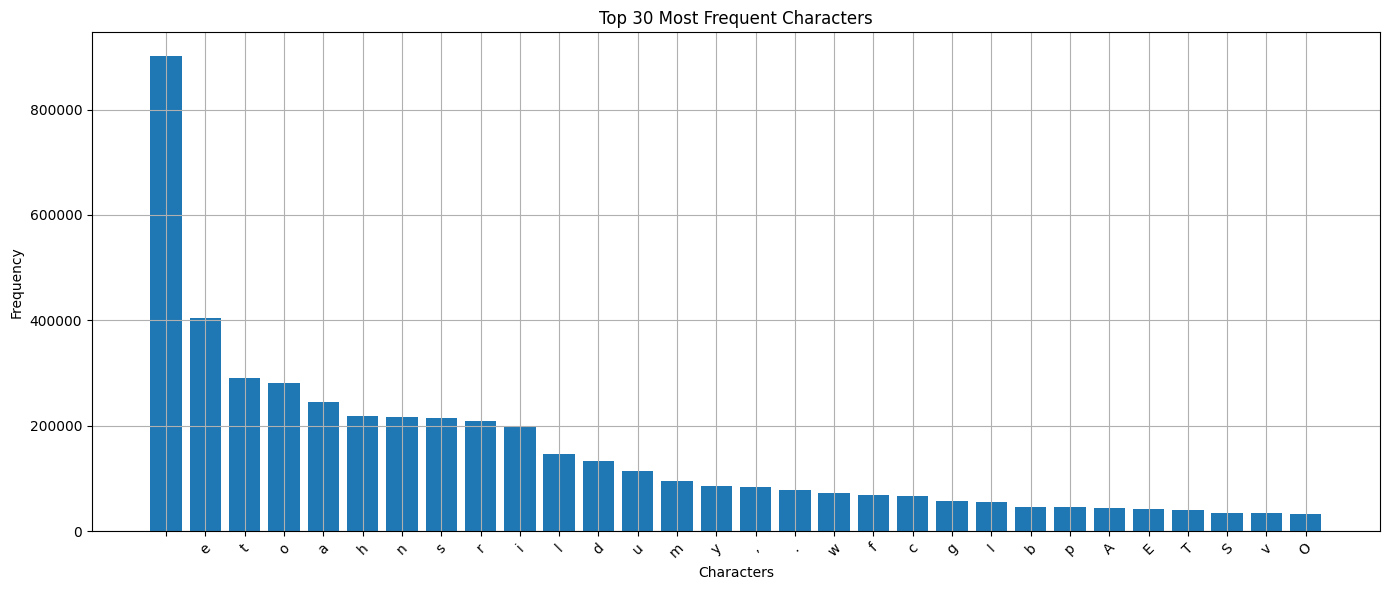

In [50]:

# Detailed Data Exploration
# Character frequency
char_counts = Counter(text)
chars, freqs = zip(*sorted(char_counts.items(), key=lambda x: -x[1]))
plt.figure(figsize=(14, 6))
plt.bar(chars[:30], freqs[:30])
plt.title("Top 30 Most Frequent Characters")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Character type distribution
upper = sum(1 for c in text if c.isupper())
lower = sum(1 for c in text if c.islower())
digits = sum(1 for c in text if c.isdigit())
spaces = sum(1 for c in text if c.isspace())
symbols = len(text) - upper - lower - digits - spaces

char_type_labels = ['Uppercase', 'Lowercase', 'Digits', 'Whitespace', 'Symbols']
char_type_values = [upper, lower, digits, spaces, symbols]

plt.figure(figsize=(7, 5))
sns.barplot(x=char_type_labels, y=char_type_values)
plt.title("Character Type Distribution")
plt.ylabel("Count")
plt.grid(True)
plt.show()

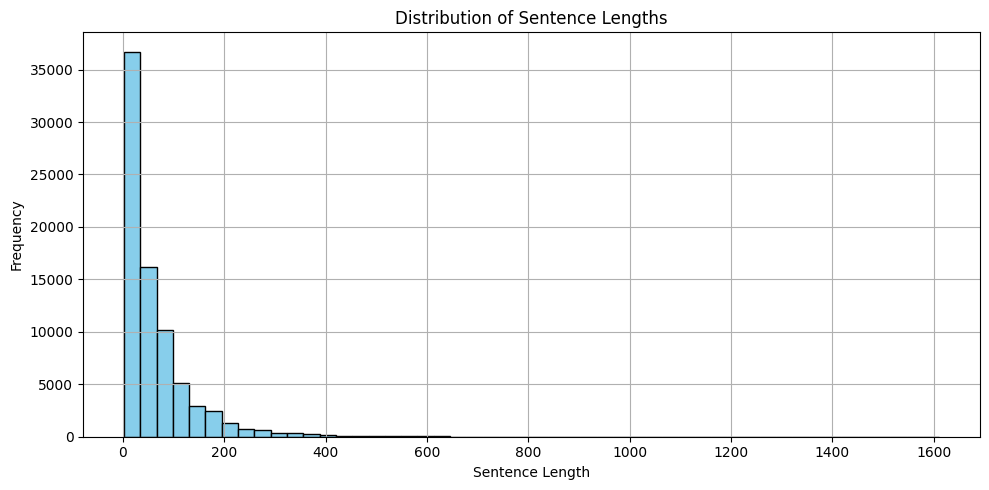

In [ ]:
# Sentence length distribution
sentence_lengths = [len(s) for s in text.split('.') if len(s.strip()) > 1]
plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

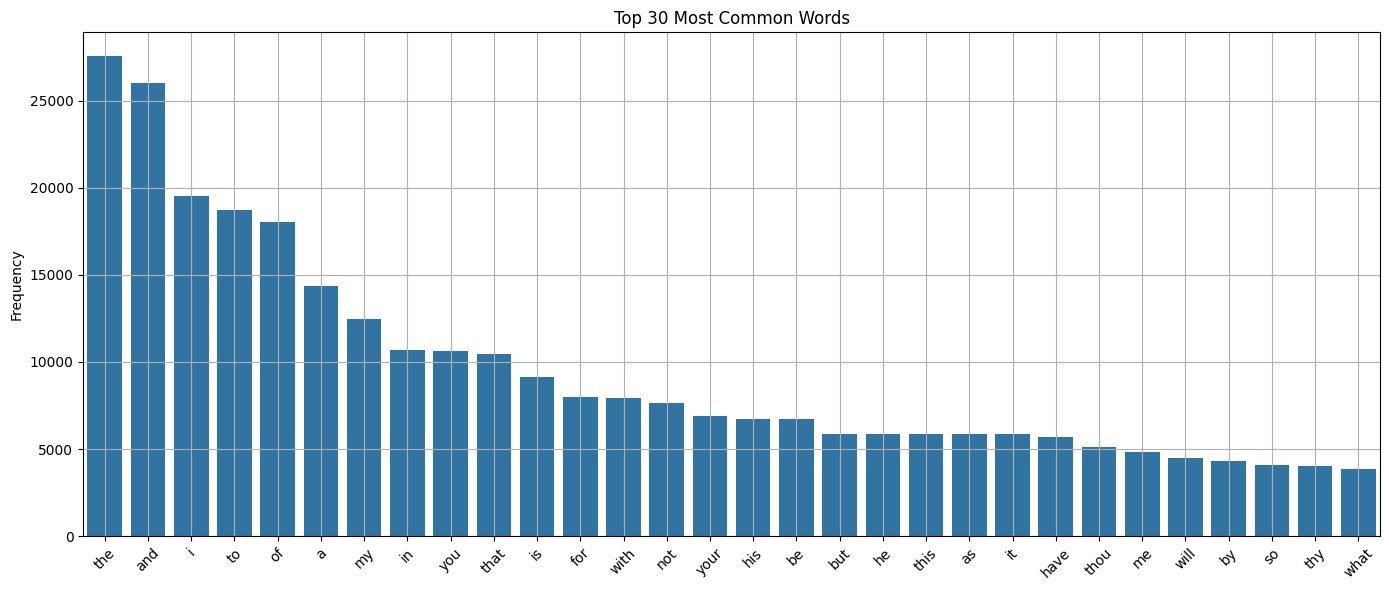

In [ ]:
# Word frequency distribution
words = text.lower().split()
word_counts = Counter(words)
common_words, word_freqs = zip(*word_counts.most_common(30))
plt.figure(figsize=(14, 6))
sns.barplot(x=list(common_words), y=list(word_freqs))
plt.title("Top 30 Most Common Words")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 4: Feature Engineering
vocab = sorted(set(text))
char2idx = {ch: idx for idx, ch in enumerate(vocab)}
idx2char = {idx: ch for idx, ch in enumerate(vocab)}
encoded_text = np.array([char2idx[c] for c in text])

with open("../data/char2idx.pkl", "wb") as f:
    pickle.dump(char2idx, f)
with open("../data/idx2char.pkl", "wb") as f:
    pickle.dump(idx2char, f)

In [ ]:
#Model Definitions
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden


class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

In [ ]:
def train_model(model_class, name, vocab_size, data, embedding_dim, hidden_dim,
                num_layers, dropout, lr, batch_size, seq_length, epochs=20, patience=5, max_samples=None):

    model = model_class(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()


    # Dataset Preparation with optional sample limit
    class TextDataset(torch.utils.data.Dataset):
        def __init__(self, data, seq_len, max_samples=None):
            self.data = data
            self.seq_len = seq_len
            self.total_len = len(data) - seq_len
            if max_samples:
                self.total_len = min(self.total_len, max_samples)

        def __len__(self):
            return self.total_len

        def __getitem__(self, idx):
            return (
                torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long),
                torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long),
            )

    dataset = TextDataset(data, seq_length, max_samples=max_samples)
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_ds, val_ds = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    best_val_loss = float('inf')
    best_val_acc = 0.0
    early_stop_counter = 0
    val_losses, val_accuracies, perplexities = [], [], []

    os.makedirs("../data/model", exist_ok=True)
    os.makedirs("../evaluation", exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        all_preds, all_labels = [], []

        print(f"\nEpoch {epoch+1}/{epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for x_batch, y_batch in train_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output, _ = model(x_batch)
            loss = loss_fn(output.view(-1, vocab_size), y_batch.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            train_loss += loss.item()

            all_preds.extend(output.argmax(-1).detach().cpu().numpy().flatten())
            all_labels.extend(y_batch.detach().cpu().numpy().flatten())

        train_acc = accuracy_score(all_labels, all_preds)

        # Validation
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for x_batch, y_batch in val_bar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output, _ = model(x_batch)
                loss = loss_fn(output.view(-1, vocab_size), y_batch.view(-1))
                val_loss += loss.item()
                val_preds.extend(output.argmax(-1).detach().cpu().numpy().flatten())
                val_labels.extend(y_batch.detach().cpu().numpy().flatten())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        perplexity = np.exp(val_loss)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        perplexities.append(perplexity)

        print(f"-- Epoch {epoch+1}: TrainAcc={train_acc:.4f} | ValLoss={val_loss:.4f} | ValAcc={val_acc:.4f} | PPL={perplexity:.2f}")

        # Save best models
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"../data/model/{name}_best_loss.pth")
            early_stop_counter = 0  # Reset counter on improvement
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(" Early stopping triggered.")
                break

    return {
        "Model": name,
        "Embedding Dim": embedding_dim,
        "Hidden Dim": hidden_dim,
        "Num Layers": num_layers,
        "Dropout": dropout,
        "LR": lr,
        "Batch Size": batch_size,
        "Best Val Loss": min(val_losses),
        "Best Val Accuracy": max(val_accuracies),
        "Best Perplexity": min(perplexities)
    }


In [ ]:
# Set device again for safety
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use actual encoded text and vocab from earlier preprocessing
vocab_size = len(vocab)

# Grid Setup for hyperparameter tuning
embedding_dims = [128, 256]
hidden_dims = [256, 512]
num_layers_list = [2]
dropouts = [0.0, 0.3]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
seq_length = 100



model_classes = {"GRU": GRU, "LSTM": LSTM}

grid = list(product(model_classes.keys(), embedding_dims, hidden_dims, num_layers_list, dropouts, learning_rates, batch_sizes))


# Run Grid Search
results = []
for model_name, emb, hid, layers, drop, lr, batch in grid:
    model_class = model_classes[model_name]
    model_id = f"{model_name}_emb{emb}_hid{hid}_layers{layers}_drop{drop}_lr{lr}_batch{batch}"
    result = train_model(model_class, model_id, vocab_size, encoded_text,
                         embedding_dim=emb, hidden_dim=hid,
                         num_layers=layers, dropout=drop,
                         lr=lr, batch_size=batch, seq_length=seq_length, max_samples=10000)
    results.append(result)


Epoch 1/20


-- Epoch 1: TrainAcc=0.6295 | ValLoss=0.2243 | ValAcc=0.9523 | PPL=1.25

Epoch 2/20


-- Epoch 2: TrainAcc=0.9671 | ValLoss=0.1243 | ValAcc=0.9687 | PPL=1.13

Epoch 3/20


-- Epoch 3: TrainAcc=0.9712 | ValLoss=0.1171 | ValAcc=0.9696 | PPL=1.12

Epoch 4/20


-- Epoch 4: TrainAcc=0.9719 | ValLoss=0.1154 | ValAcc=0.9702 | PPL=1.12

Epoch 5/20


KeyboardInterrupt: 

In [ ]:
# Save and show results
df_results = pd.DataFrame(results)
df_results.to_csv("../evaluation/final_hyperparameter_results.csv", index=False)


In [ ]:
df_results

,Model,Embedding Dim,Hidden Dim,Num Layers,Dropout,LR,Batch Size,Best Val Loss,Best Val Accuracy,Best Perplexity
0,GRU_emb128_hid256_layers1_drop0.0_lr0.003_batch64,128,256,1,0.0,0.003,64,0.110803,0.970875,1.117175
1,GRU_emb128_hid256_layers1_drop0.0_lr0.003_batc...,128,256,1,0.0,0.003,128,0.145162,0.968415,1.156227
2,GRU_emb128_hid256_layers1_drop0.0_lr0.001_batch64,128,256,1,0.0,0.001,64,0.230487,0.959950,1.259214
3,GRU_emb128_hid256_layers1_drop0.0_lr0.001_batc...,128,256,1,0.0,0.001,128,0.934262,0.735140,2.545334
4,GRU_emb128_hid256_layers1_drop0.3_lr0.003_batch64,128,256,1,0.3,0.003,64,0.113382,0.970630,1.120060
...,...,...,...,...,...,...,...,...,...,...
123,LSTM_emb256_hid512_layers2_drop0.0_lr0.001_bat...,256,512,2,0.0,0.001,128,0.185012,0.963425,1.203232
124,LSTM_emb256_hid512_layers2_drop0.3_lr0.003_bat...,256,512,2,0.3,0.003,64,0.091344,0.971710,1.095646
125,LSTM_emb256_hid512_layers2_drop0.3_lr0.003_bat...,256,512,2,0.3,0.003,128,0.097043,0.971105,1.101908
126,LSTM_emb256_hid512_layers2_drop0.3_lr0.001_bat...,256,512,2,0.3,0.001,64,0.105413,0.969295,1.111170


In [ ]:
# Create combined score
df_results['Combined Score'] = df_results['Best Val Accuracy'] / df_results['Best Perplexity']

# Step 2: Filter for GRU and LSTM
gru_results = df_results[df_results['Model'].str.startswith('GRU')]
lstm_results = df_results[df_results['Model'].str.startswith('LSTM')]

# Step 3: Find best for each
best_gru = gru_results.loc[gru_results['Combined Score'].idxmax()]
best_lstm = lstm_results.loc[lstm_results['Combined Score'].idxmax()]

# Step 4: Print results
print(" Best GRU Model:\n", best_gru)
print("\n Best LSTM Model:\n", best_lstm)


 Best GRU Model:
 Model                GRU_emb256_hid512_layers2_drop0.3_lr0.003_batch64
Embedding Dim                                                      256
Hidden Dim                                                         512
Num Layers                                                           2
Dropout                                                            0.3
LR                                                               0.003
Batch Size                                                          64
Best Val Loss                                                 0.094292
Best Val Accuracy                                              0.97216
Best Perplexity                                                1.09888
Combined Score                                                0.884682
Name: 60, dtype: object

 Best LSTM Model:
 Model                LSTM_emb256_hid512_layers2_drop0.3_lr0.003_bat...
Embedding Dim                                                      256
Hidden Dim     

In [ ]:
def generate_text(model_class, checkpoint_path, seed_text, char2idx, idx2char, vocab_size,
                  embedding_dim, hidden_dim, num_layers=1, temperature=1.0, gen_length=300):
    
    # Prepare the model
    model = model_class(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    # Encode the seed text
    input_eval = torch.tensor([char2idx[c] for c in seed_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(seed_text)

    hidden = None
    with torch.no_grad():
        for _ in range(gen_length):
            output, hidden = model(input_eval, hidden)
            predictions = output[:, -1, :] / temperature  # shape: (1, vocab_size)
            probs = torch.softmax(predictions, dim=-1).squeeze().cpu().numpy()
            next_char_idx = np.random.choice(len(probs), p=probs)
            next_char = idx2char[next_char_idx]
            generated.append(next_char)

            input_eval = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return ''.join(generated)


In [ ]:
# Load mappings
with open("../data/char2idx.pkl", "rb") as f:
    char2idx = pickle.load(f)
with open("../data/idx2char.pkl", "rb") as f:
    idx2char = pickle.load(f)

# Params must match the ones used during training
checkpoint_path = "../data/model/LSTM_emb256_hid512_layers2_drop0.3_lr0.003_batch64_best_loss.pth"  # example
model_class = LSTM
generated_text = generate_text(model_class, checkpoint_path, seed_text="i am the very model of a modern major general", 
                               char2idx=char2idx, idx2char=idx2char,
                               vocab_size=len(char2idx), embedding_dim=256, hidden_dim=512, num_layers=2)

print(generated_text)


i am the very model of a modern major general food at first, Which you do live upon; and fit it is, Because I am the store-house and the shop Of the whole body: but, if you do remember, I send it through the rivers of your blood, Even to the court, the heart, to the seat o' the brain; And, through the cranks and offices of man, The strongest n
